# Dimensional reduction (PCA)

In [29]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_auc_score

%matplotlib inline


So far we have dealt with relatively small datasets in terms of number of independent variables. However, we can get into some problems when using them:


* Algorithm takes an extremely long time to work

* The higher the number of dimensions, the more variation we add to the dataset and the less precise our fits become

* Not every single independent variable we see adds significant prediction information, some only add noise.


We can reduce the number of independent variables we use and obtain good fits by summarizing groups of them. The way in which principal component analysis (PCA) does this is by projection. 

The idea is simple, first draw a plane across the direction of your points that has the highest variance:

![PCA01](PCA01.png)

We then do perpendicular projection on to this plane and use the projected points as our new features:

![PCA02](PCA02.png)

We call the resulting number of dimensions after projecting "principal components." Principal components don't have an interpreatable meaning, as they are not the original variables, but they act like a summary of them. 

We do lose a bit of interpretability at each component since we are eliminating the variation of things away from the plane on which we project. 

Another thing we need to emphasize is that before doing any projections the features need to be of comparable scale or the summaries will not really be truly representative. 

Let's start an example with the iris dataset


In [2]:
#Let's load our iris dataset

iris = datasets.load_iris()


In [3]:
iris_df = pd.DataFrame(iris.data,columns=iris.feature_names)
iris_df['label']=pd.Series(iris.target)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


If we wanted to explore the data through plots for each of the four dimensions, we would need to plot the following: 

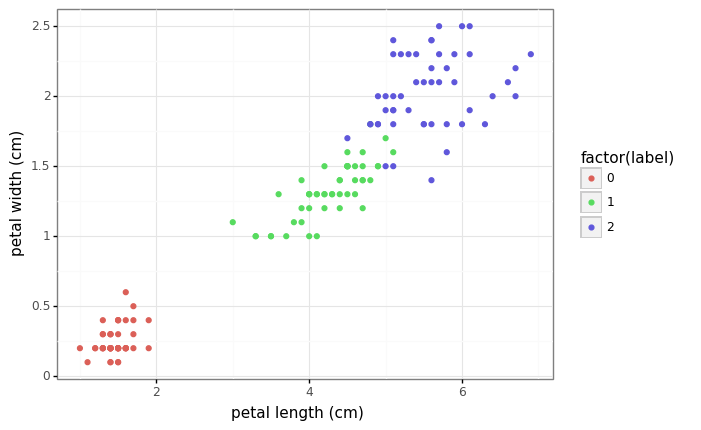

<ggplot: (8783179529469)>

In [24]:
(ggplot(data=iris_df, mapping=aes(x='petal length (cm)',
                                 y='petal width (cm)', color='factor(label)'))+
geom_point()+
theme_bw())

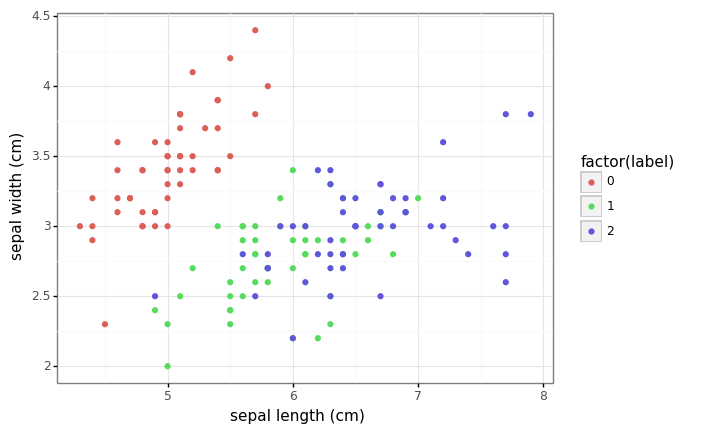

<ggplot: (8783158491094)>

In [25]:
(ggplot(data=iris_df, mapping=aes(x='sepal length (cm)',
                                 y='sepal width (cm)', color='factor(label)'))+
geom_point()+
theme_bw())

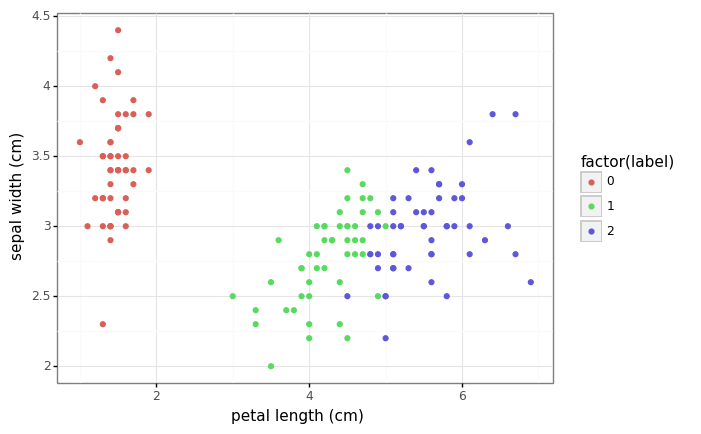

<ggplot: (8783124408357)>

In [26]:
(ggplot(data=iris_df, mapping=aes(x='petal length (cm)',
                                 y='sepal width (cm)', color='factor(label)'))+
geom_point()+
theme_bw())

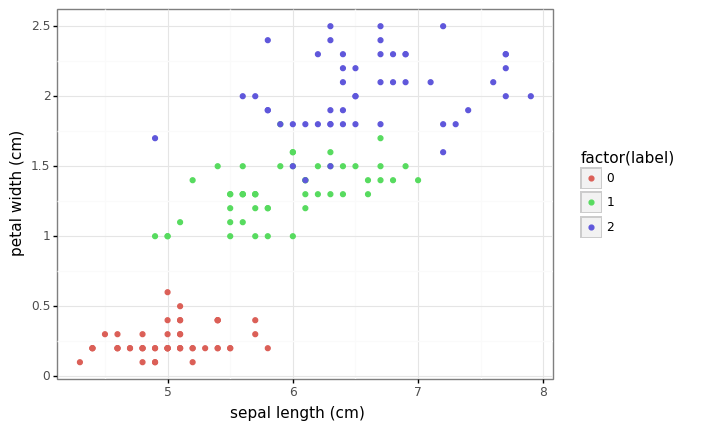

<ggplot: (8783158534355)>

In [27]:
(ggplot(data=iris_df, mapping=aes(x='sepal length (cm)',
                                 y='petal width (cm)', color='factor(label)'))+
geom_point()+
theme_bw())

This is a bit overwhelming and hard to understand. This is one of the reasons why summarizing is important.

In [6]:
#Let's save the feature names in a list so we can call them

features=iris.feature_names

features

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

As you recall, we said that before we did anything with PCA, we need to make sure that the features are all comparable. A way to do this is "standarizing" a variable. This means expressing it in terms of number of standard deviations away from the mean. Ergo for each observation $i$ 

$$Standarized(X_i)=\frac{X_i-mean(X)}{sd(X)}$$


This makes all of our features be of comparable scale! We have a method in sklearn that lets us do this automatically (StandardScaler).

In [8]:
#Separate the target
y=iris_df['label']


#Get the features:
X=iris_df[features]

#scale the features

X=StandardScaler().fit_transform(X)


Let's compare the unscaled and scaled features:

In [10]:
pd.DataFrame(X).head()

,0,1,2,3
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [12]:
iris_df[features].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Note that a lot of our observations in the standarized version are more similar across columns in magnitude than the non scaled ones.

Let's do a PCA that ends with 2 components

In [16]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

In [19]:
#Let's make a dataframe with principal components

principal_df=pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

principal_df['label']=y

principal_df.head()

,PC1,PC2,label
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0
3,-2.299384,-0.597395,0
4,-2.389842,0.646835,0


We have now summarized the 4 dimensions into 2! Let's see how they look:

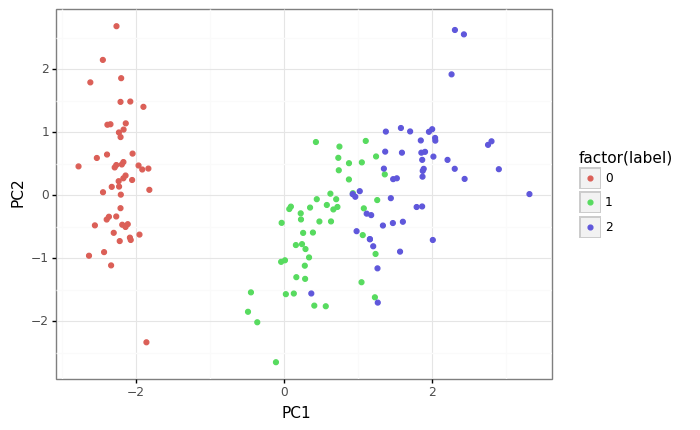

<ggplot: (8783158436855)>

In [20]:
(ggplot(data=principal_df, mapping=aes(x='PC1',
                                       y='PC2', color='factor(label)'))+
geom_point()+
theme_bw())

We can check what proportion of variance is explained by each extra component

In [22]:
#print the explained

exp_var=pca.explained_variance_ratio_

exp_var

array([0.72962445, 0.22850762])

The total explained variance from the whole summarization is the sum of these numbers, the first component explains 72% of the variance, and the following component explains an additional 22%. The rest is lost from the process of projection. Let's look at the total explained by doing a cumulative sum:

In [23]:
np.cumsum(exp_var)

array([0.72962445, 0.95813207])

Alright, let's work with a much harder example now. We will be using the MNIST dataset which contains data for handwritten digits. The data looks like this:

![MNIST examples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Our labels will be the actual number labels, and our independent variables will be the values of how dark the pixel in each row are! Each picture will be of 28 X 28 pixels leaving us with 784 features! More than we have ever used! Let's load the data (it will take a while)

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

Let's look at the shape

In [33]:
mnist.data.shape

(70000, 784)

This is a huge dataset. Let's do a train test split for our models:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, test_size=0.15, random_state=42)

As we said, we need to scale the independent variable data, so let's do that now, and let's have the standarization happen around the training data since that is what we will use for fitting a new classification model:

In [35]:
X_train=StandardScaler().fit(X_train).transform(X_train)
X_test=StandardScaler().fit(X_train).transform(X_test)

Now, we will use logistic regression to do fitting of the model when we transform the data to different numbers of principal components, explaining only a part of the variance, we will use 100% (no PCA used), 95%, 90%, 85% and 80%. We will be comparing the accuracy score in this case.




In [44]:
lr=LogisticRegression(max_iter=10000)

Let's create some empty lists to fill the info we will use to evaluate

In [51]:
Components=[]
VarianceExplained=[]
Score=[]

In [45]:
#Instantiate the fit

lr.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [46]:
#Instantiate the prediction score

accuracy1=lr.score(X_test, y_test)
accuracy1


0.8320952380952381

In [48]:
#Without PCA our number of components is:
comp1=784

In [52]:
#Our total variance explained in this case is 1

varexp1=1

In [53]:
#Let's append on the lists

Components.append(comp1)
VarianceExplained.append(varexp1)
Score.append(accuracy1)


Let's make a list to save all the possible variance explained we want:

In [55]:
varex=[0.95, 0.90, 0.85, 0.8]

Now we will make a for loop to save all of our results in the lists we started and then make a dataframe

In [68]:
for var in varex:
    
    pc1=PCA(var).fit(X_train)
    
    X1_train=pc1.transform(X_train)
    
    X1_test=pc1.transform(X_test)
    
    #Instantiate fit
    
    lr.fit(X1_train, y_train)
    
    #Get Prediction score
    
    acc=lr.score(X1_test, y_test)
    
    #save results
    
    Components.append(X1_train.shape[1])
    VarianceExplained.append(var)
    Score.append(acc)
    


In [77]:
#creating a dataframe

results_df=pd.DataFrame()
results_df['Number of components']=Components
results_df['Variance Explained']=VarianceExplained
results_df['Accuracy']=Score

In [78]:
results_df

,Number of components,Variance Explained,Accuracy
0,784,1.00,0.832095
1,330,0.95,0.837905
2,235,0.90,0.834381
3,184,0.85,0.831048
4,148,0.80,0.830190


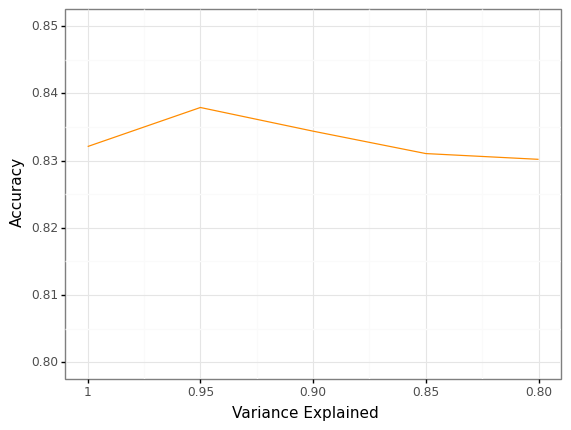

<ggplot: (8782944413260)>

In [87]:
(ggplot(data=results_df, mapping=aes(x='Variance Explained',
                                     y='Accuracy'))+
geom_line(color='darkorange')+
 scale_x_reverse()+
 ylim([0.8, 0.85])+
 theme_bw()
)

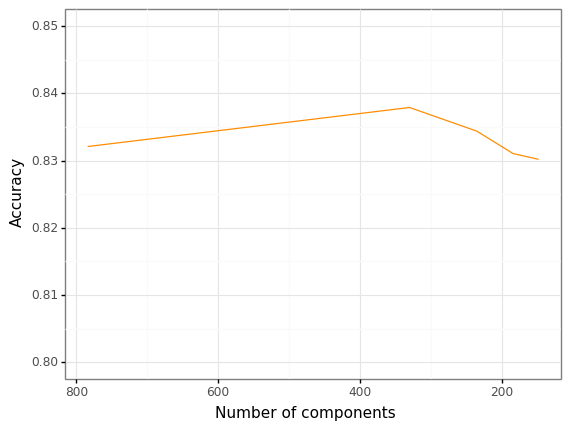

<ggplot: (8783179525687)>

In [88]:
(ggplot(data=results_df, mapping=aes(x='Number of components',
                                     y='Accuracy'))+
geom_line(color='darkorange')+
 scale_x_reverse()+
 ylim([0.8, 0.85])+
 theme_bw()
)
